In [31]:
import torch
from torch.nn import functional as F
from torch import nn 

torch.manual_seed(69)

In [27]:
B, T, C = 4, 5, 2

x = torch.randn(B,T,C)

tril = torch.tril(torch.ones(T,T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float("-inf"))
wei = F.softmax(wei, dim=1)
out = wei @ x
out.shape

torch.Size([4, 5, 2])

In [29]:
x

tensor([[[-4.7304e-01,  3.8990e-01],
         [ 2.0513e+00,  7.4940e-01],
         [ 1.2193e+00, -1.6536e+00],
         [-1.0109e+00, -8.3177e-01],
         [ 8.0288e-01, -3.5990e-01]],

        [[ 1.0008e+00,  1.5579e-03],
         [-8.0353e-01, -6.0771e-01],
         [ 7.9591e-01, -1.1940e+00],
         [ 4.9793e-01,  2.3756e-01],
         [-1.1089e+00, -4.3322e-01]],

        [[ 8.9922e-01,  6.3328e-03],
         [ 2.1820e-01, -3.7427e-01],
         [ 5.4758e-01, -3.7995e-01],
         [-2.3314e-01,  5.2713e-03],
         [ 2.9274e-01, -5.1948e-01]],

        [[-6.6530e-01, -6.0000e-01],
         [-5.9538e-01,  4.9100e-01],
         [-5.9860e-01, -4.7781e-01],
         [ 3.9303e-01, -3.9383e-03],
         [-1.4752e+00, -1.6426e-01]]])

In [28]:
out # moving average hidding the future from the model

tensor([[[-0.4730,  0.3899],
         [ 0.7891,  0.5697],
         [ 0.9325, -0.1714],
         [ 0.4467, -0.3365],
         [ 0.5179, -0.3412]],

        [[ 1.0008,  0.0016],
         [ 0.0986, -0.3031],
         [ 0.3311, -0.6001],
         [ 0.3728, -0.3907],
         [ 0.0764, -0.3992]],

        [[ 0.8992,  0.0063],
         [ 0.5587, -0.1840],
         [ 0.5550, -0.2493],
         [ 0.3580, -0.1857],
         [ 0.3449, -0.2524]],

        [[-0.6653, -0.6000],
         [-0.6303, -0.0545],
         [-0.6198, -0.1956],
         [-0.3666, -0.1477],
         [-0.5883, -0.1510]]])

Self attention workings :
    Every Token will emit two vectors : Query and a Key 
    The Query vector = What am I looking for ?
    The Key vector = What do I contain ?

    Affinity is computed using the dot product between Query and Key. Remember the SVD system recommendation.

    My Query .Product with all the keys. That dot product becomes "wei" above

    If the Key and Query are aligned, they will interact with High amount !

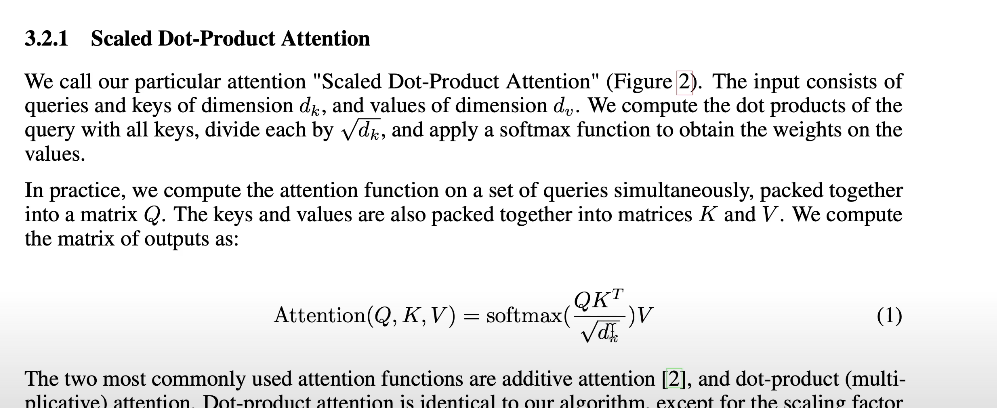

In [36]:
B, T, C = 4, 5, 32

x = torch.randn(B,T,C)

head_size = 16
key = nn.Linear(C, head_size, bias=False) # bias False, apply matrix multiply with some fixed weights
query = nn.Linear(C, head_size, bias=False) 

# All the tokens is parallel (B,T) produce a key and a query !
k = key(x) # (B, T, head_size)
q = query(x) # (B, T, head_size) => in other terms dim = (-3,-2,-1)

# we want dot product for affinity calculation 

wei = q @ k.transpose(-2,-1) # (B,T, 16) @ (B,16, T) ==> (B,T,T)

tril = torch.tril(torch.ones(T,T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float("-inf"))
wei = F.softmax(wei, dim=1)

# This is called self attention because all the input is coming from the same source x
out = wei @ x
out.shape

torch.Size([4, 5, 32])

In [33]:
q.shape

torch.Size([4, 5, 16])

In [50]:
q.transpose(-2,-1).shape

torch.Size([4, 16, 5])

In [53]:
k = torch.randn(B,T, head_size)
q = torch.randn(B,T, head_size)# gaussian mean 0 var = 1

wei = q @ k.transpose(-2,-1) * head_size ** -0.5 # we multiply by inverse root head_size to normalize the variance to 1
# Because it will be used by softmaw, it is important that wei be fairly diffused ! 
# Softmax converges to one hot vector if an element is sharp.
wei

tensor([[[  0.8786,  -3.4437,   0.9385,   1.6357,   4.4001],
         [  3.3244,  -2.3567,  -6.6574,   0.7192,   1.5374],
         [  0.5860,   0.6850,  -1.9857,   5.1271,   1.8204],
         [  1.1401,   0.1586,  -5.7047,  -4.2961,  -1.5503],
         [  1.2181,   0.8870,  -4.6870,   2.7039,  -1.8624]],

        [[ -0.7553,   3.8820,  -3.9459,   0.3130,  -2.4067],
         [  2.2544,  -2.8271,  -0.0405,   3.5896,  -4.6327],
         [  1.6492,   1.6304,   5.3923,   4.3199,   5.8977],
         [  2.1083,  -3.1605,  -0.5120,  -3.4428, -10.4878],
         [  1.7880,   3.1963,  -3.2104,   1.7611,  -1.5088]],

        [[  3.2569,  -1.7272,  -2.3653,   1.4867,   1.4258],
         [ -5.9106,   1.5787,   0.4741,   1.1219,   0.5291],
         [  5.2868,  -0.4570,  -1.6664,  -1.6440,  -1.4181],
         [ -0.4304,  -2.7289,   2.2751,  -1.8919,  -6.8065],
         [ -4.9824,  -2.6429,   2.4742,  -1.9339,  -2.7989]],

        [[ -3.1516,   8.3792,   1.1362,  -1.5590,  -0.8687],
         [ -7.4093

In [54]:
print("variance, q.var = ",q.var(), " k.var = ", k.var(), " q@k.T .var ",wei.var())

variance, q.var =  tensor(1.1620)  k.var =  tensor(0.9351)  q@k.T .var  tensor(12.7202)


In [45]:
import torch

# Create a 2D tensor (matrix)
A = torch.tensor([[1, 2, 3],
                  [4, 5, 6]])

# Transpose the matrix
A_transposed = A.transpose(-2, -1)

print("Original matrix:\n", A)
print("Transposed matrix:\n", A_transposed)


Original matrix:
 tensor([[1, 2, 3],
        [4, 5, 6]])
Transposed matrix:
 tensor([[1, 4],
        [2, 5],
        [3, 6]])


In [ ]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out
    
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        
        return torch.cat([h(x) for h in self.heads], dim=-1)
        # out = torch.cat([h(x) for h in self.heads], dim=-1)
        # out = self.dropout(self.proj(out))
        # return out

    import torch 
import torch.nn as nn
from torch.nn import functional as F 
torch.manual_seed(69)
n_embd = 5
block_size = 4

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token will be projected into a 13*13 dimension
        # Given a context of words, what is its meaning in our world (vocab dimension)
        # what is also happening befin the scene is that each token is encode into a one hot encoder before feedforward
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)

        # We need to encode the position of tokens too ! 
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.sa_head = Head(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    # TODO : why this is just bigram ?
    def forward(self, x, targets=None):

        # row, colums ! BATCH, CONTEXT (time)
        # x and targets are both (B,T) tensor of integers

        tok_emb = self.token_embedding_table(x) # Will be transformed into -> BATCH, CONTEXT, VOCAB_SIZE = Channel !
        pos_emb = self.position_embedding_table(torch.arrange(x))

        x = tok_emb + pos_emb # (B, T, C) we need to keep both the token and its position.
        
        x = self.sa_head(x) # apply one head of self attention !

        logits = self.lm_head(x) # decoder (B, T, vocab_size)

        if targets is None:
            loss = None 
        else:
            B, T, C = logits.shape
            
            # TODO: to draw
            logits = logits.view(B*T,C)
            targets = targets.view(B*T) # Targets are of shape B*T and we want to strech them over the Channel

            loss = F.cross_entropy(logits, targets) # it want a B,T,C instead of a B,C,T
        
        return logits, loss
    
    def generate(self, x, max_new_tokens):
        
        # x is (BATCH, CONTEXT=TIME) array of indices in the current context
        for _ in range(max_new_tokens):


            x = x[:,-block_size:]
            # get the predictions 
            logits, loss = self(x) # B,T
            # focus only on the last time step
            # TODO : Draw !
            logits = logits[:,-1,:] # comes as B,T,C becomes B,C as T is fetched
            # apply softmax to get the prob
            probs = F.softmax(logits,dim=1) # B,C

            # Sample from the distribution :
            x_next = torch.multinomial(probs, num_samples=1) # B,1
            # append sampled index to the running sequence :
            x = torch.cat((x,x_next),dim=1) # B, T+1
        return x